Trees

In [1]:
import os
import re
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.tree as tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import warnings

In [3]:
os.getcwd()
# from thon.Choose import choose_features
from thon.churn import rollover, save_model, tree_importance, plot_eval, bake_pred
# data = choose_features("data/out/features.csv", cv_range = (0, 10), save = False)

In [4]:
# features are automatically trimmed
data = pd.read_csv("./data/out/features.csv")
data.columns

Index(['month', 'n', 'unemp_lag12', 'unempt5w_lag12', 'unemp5tp14w_lag12',
       'unemp15ov...5_lag9', 'unemp15ov...6_lag9', 'oilimport_lag12',
       'ngspot_lag3', 'hcpi_lag3', 'food_lag12', 'sahmrule_lag3',
       'discount_lag3', 'localrent_lag3', 'durable_lag9', '10yinf_lag12',
       'kwhcost_lag3', 'sentiment_lag3', 'new_units_lag6', 'altsales_lag3',
       'totalsa_lag3', 'ltrucksa_lag3', 'tmaturity_lag12', 'carcpi_lag12',
       'newhouses_lag3', 'pempltot_lag3', 'pemplmanuf_lag3', 'pemplfin_lag3',
       'laborpart_lag3', 'prodmanuf_lag9', 'overmanuf_lag6', 'wagemanuf_lag12',
       'fedsurplus_lag3', 'industry_lag9', 'industrycg_lag9',
       'industryut_lag9', 'caput_lag9', 'hcpiurban_lag3', 'stuffcpi_lag12',
       'retail_lag12', 'sales_lag12', 'manufsales_lag12', 'manufinv_lag12',
       'cbpy30_lag3', 'fedfundseff_lag3', 'treasurymat1_lag3',
       'treasurymat5_lag3', 'treasurymat7_lag3', 'treasurymat10_lag3',
       'F_lag12', 'F_v_lag6', 'AN_lag12', 'AN_v_lag3', 'MZ

In [6]:
# Training data
X, y = data.drop(columns = ['n']), data[['n']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, shuffle = False)

In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

In [8]:
search = GridSearchCV(pipeline,
                      {'model__max_depth':np.arange(2, 20, 1),
                      'model__ccp_alpha':np.arange(0, 5, 0.1)},                      
                      cv = 5,
                      scoring = 'neg_mean_squared_error',
                      verbose = 1)

In [9]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', DecisionTreeRegressor())]),
             param_grid={'model__ccp_alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                         'model__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])},
             scoring='neg_mean_squared_error', verbose=1)

In [38]:
search.best_params_

{'model__ccp_alpha': 1.8, 'model__max_depth': 2}

In [42]:
# Training data

treemodel = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor(ccp_alpha=1.8, max_depth=5))    
])
# Train the model
treemodel.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
train_pred = pd.Series(treemodel.predict(X_train), index=X_train.index)
test_pred = pd.Series(treemodel.predict(X_test), index=X_test.index)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeRegressor(ccp_alpha=1.8, max_depth=2))])

In [43]:
train_pred = train_pred.sort_index()
y_train = y_train.sort_index()
test_pred = test_pred.sort_index()
y_test = y_test.sort_index()

226.16403215831787
2.153943163412551


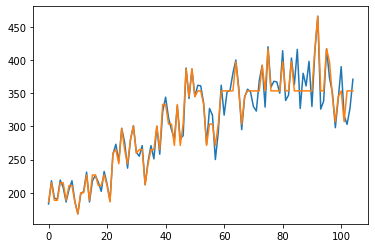

In [44]:
plot_eval(train_pred, y_train)

12400.574012855832
275.5683113967963


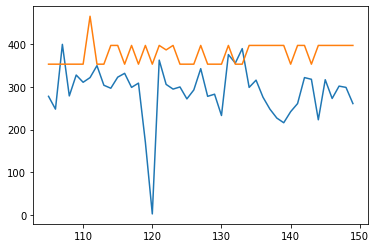

In [45]:
plot_eval(test_pred, y_test)

In [15]:
text_representation = tree.export_text(treemodel, feature_names = list(X_train))
print(text_representation)

|--- localrent_lag3 <= 273.61
|   |--- retail_lag12 <= 333482.00
|   |   |--- value: [203.91]
|   |--- retail_lag12 >  333482.00
|   |   |--- value: [264.41]
|--- localrent_lag3 >  273.61
|   |--- BWA_v_lag6 <= 29706808.00
|   |   |--- value: [318.88]
|   |--- BWA_v_lag6 >  29706808.00
|   |   |--- value: [365.79]



In [16]:
# feature names used in model
imp = tree_importance(treemodel, X_train.columns)

In [17]:
save_model(treemodel, "treemodel.pkl")

In [18]:
imp.sort_values("importance", ascending = False)

,importance
localrent_lag3,0.833475
retail_lag12,0.085074
BWA_v_lag6,0.081451
month,0.000000
TM_lag12,0.000000
...,...
pemplmanuf_lag3,0.000000
pempltot_lag3,0.000000
newhouses_lag3,0.000000
carcpi_lag12,0.000000


In [19]:
newdata = rollover(imp)

C:\Users\keato\Documents\LocalRStudio\LJ_Leading_Indicators\thon\churn.py:33: UserWarning: Features are named incorrectly, they are led 3 months ahead of their label
  warnings.warn("Features are named incorrectly, they are led 3 months ahead of their label")


In [20]:
newdata

,month,unemp_lag12,unempt5w_lag12,unemp5tp14w_lag12,unemp15ov...5_lag9,unemp15ov...6_lag9,oilimport_lag12,ngspot_lag3,hcpi_lag3,food_lag12,...,g_new_cars_lag3,g_used_cars_lag3,g_cars_for_sale_lag3,g_car_for_sale_near_me_lag3,g_best_new_cars_lag3,g_how_to_buy_a_car_lag9,g_dealership_near_me_lag3,g_dealerships_near_me_lag3,bin,m_num
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# predict
pred = treemodel.predict(newdata)
pred

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [22]:
full = bake_pred(y_train, y_test, pred)

NameError: name 'pred' is not defined

In [40]:
full.to_csv("data/out/tree.csv")

In [23]:
full

NameError: name 'full' is not defined